In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import optuna
from sklearn.model_selection import cross_val_score

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [ ]:
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")
X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score"]




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clean = cleaning_pipeline()
prep = preprocessing_pipeline()

/tmp/ipykernel_60087/2656887457.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


In [3]:
gbc_clf = Pipeline([
    ("clean", clean),
    ("prep", prep),
    ("ada_clf", GradientBoostingClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

cv_result_base = cross_validate(
    gbc_clf,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=6,
    verbose=1,
    return_train_score=False
)

cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_base_metrics = {**cv_base_metrics_mean, **cv_base_metrics_std}
pd.DataFrame([cv_base_metrics])

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warning

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.703838,0.679395,0.679603,0.682884,0.679395,0.001343,0.001634,0.001175,0.001119,0.001634


In [4]:
gbc_clf.fit(X_train, y_train)

y_pred_base = gbc_clf.predict(X_test)

test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.70345,0.677551,0.67827,0.682432,0.677551


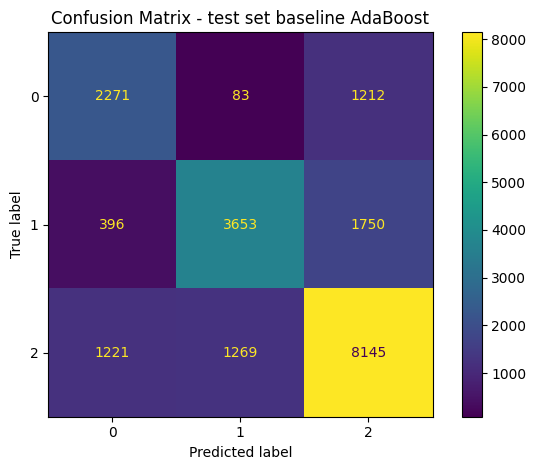

In [5]:
cm = confusion_matrix(y_test, y_pred_base)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline AdaBoost")
plt.tight_layout()
plt.show()

In [ ]:
# with mlflow.start_run(run_name="GradientBoosting_baseline"):
#     mlflow.log_metrics(cv_base_metrics)
#     mlflow.log_metrics(test_metrics_base)

🏃 View run GradientBoosting_baseline at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/b736e212a55d44ae8a48eb13ec32270a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966


In [15]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 600)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 2, 5)
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    gbc_opt = Pipeline([
        ("clean", clean),
        ("prep", prep),
        ("gbc_clf_opt", GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            max_features=max_features,
            random_state=42)),
    ])
    
    score = cross_val_score(
        gbc_opt,
        X_train,
        y_train,
        scoring="f1_macro",
        cv=cv,
        n_jobs=9,
        verbose=1,
    ).mean()
    
    return score

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2025-12-02 23:03:32,167] A new study created in memory with name: no-name-b90374ab-5625-4578-a4f8-a50dafa17233
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other 

KeyboardInterrupt: 